## Imports 

In [1]:
import json

import nltk
import pandas
from nltk.tokenize import word_tokenize

from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib

from scripts.analysis import *

In [2]:
# Download and setup TeX Gyre Pagella fonts
if not os.path.exists("fonts") or not os.path.exists("fonts/texgyrepagella-regular.otf"):
    import urllib.request
    import zipfile
    import os
    import shutil

    FONT_URL = "http://www.gust.org.pl/projects/e-foundry/tex-gyre/pagella/qpl2_501otf.zip"
    FONT_DIR = "fonts"
    ZIP_FILE = "fonts/pagella.zip"

    # Ensure fonts directory exists
    os.makedirs(FONT_DIR, exist_ok=True)

    # Check if fonts already exist
    required_fonts = ['texgyrepagella-regular.otf', 'texgyrepagella-bold.otf', 'texgyrepagella-italic.otf']
    fonts_exist = all(os.path.exists(os.path.join(FONT_DIR, font)) for font in required_fonts)

    if not fonts_exist:
        print("Downloading TeX Gyre Pagella fonts...")
        urllib.request.urlretrieve(FONT_URL, ZIP_FILE)
        
        print("Extracting fonts...")
        
        with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
            for file in zip_ref.namelist():
                if file.endswith('.otf'):
                    # Extract directly to fonts/ directory with just the filename
                    with zip_ref.open(file) as source:
                        target_path = os.path.join(FONT_DIR, os.path.basename(file))
                        with open(target_path, 'wb') as target:
                            shutil.copyfileobj(source, target)
        
        print("Cleaning up...")
        os.remove(ZIP_FILE)
        
        print(f"Done! Fonts installed to {FONT_DIR}/")
        for file in sorted(os.listdir(FONT_DIR)):
            if file.endswith('.otf'):
                print(f"  - {file}")
    else:
        print(f"Fonts already downloaded in {FONT_DIR}/")

# Load fonts
font_path = 'fonts/texgyrepagella-regular.otf'
font_manager.fontManager.addfont(font_path)
plt.rcParams['font.family'] = font_manager.FontProperties(fname=font_path).get_name()

font_path = 'fonts/texgyrepagella-regular.otf'
texgyrepagella_regular = font_manager.FontProperties(fname=font_path)

font_path = 'fonts/texgyrepagella-bold.otf'
texgyrepagella_bold = font_manager.FontProperties(fname=font_path)

font_path = 'fonts/texgyrepagella-italic.otf'
texgyrepagella_italic = font_manager.FontProperties(fname=font_path)

In [3]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


## Table results 

### Auto Baseline 


In [4]:
final_performance = load_task_final_performance("final_results/travel_planning_auto")

df = pd.DataFrame(final_performance).drop(columns=["parsed_travel_plan", "commonsense_evaluation", "travel_plan", 
"outcome"])
df.groupby(["model_name"])[["commonsense_pass_rate","preference_pass_rate","performance_rating"]].mean()

,commonsense_pass_rate,preference_pass_rate,performance_rating
model_name,,,
claude3sonnet,0.562500,0.580882,0.571691
claude40,0.640931,0.593137,0.617034
gpt4o,0.647472,0.539326,0.517770
llama3-70b,0.659091,0.616883,0.481618


### Utility 

In [5]:
for task_name in ["travel_planning"]:
    for stage in ["one", "two"]:
        
        eval_data_original = load_agent_process_eval(
            f"final_results/{task_name}_{stage}",
            fill_empty_interactions = True,
            pad_trajectories = False, 
            truncate_trajectories = False,
        )

        eval_data_original = pd.concat(eval_data_original)
        eval_data_original['user_step'] = eval_data_original['user_step'] + 1

        eval_data_original['generated_result'] = eval_data_original['evaluation'].apply(lambda x: x.get("task_completion", None) if isinstance(x, dict) else None)

        results = [] 
        for (model_name, session_name), gp in eval_data_original.groupby(["model_name", "session_name"]):

            if ~pd.isna(gp['generated_result']).all():
                first_performance_rating = gp[gp['generated_result'].notna()].iloc[0]['performance_rating']
                final_performance_rating = gp.iloc[-1]['performance_rating']
                max_performance_rating = gp['performance_rating'].max()
            else:
                first_performance_rating = gp.iloc[0]['performance_rating']
                final_performance_rating = gp.iloc[-1]['performance_rating']
                max_performance_rating = gp['performance_rating'].max()
            
            results.append([
                model_name,
                session_name,
                first_performance_rating,
                final_performance_rating,
                max_performance_rating,
            ])

        # finding the first row where generated_result is not None
        combined_df = pd.DataFrame(results, columns = ['model_name', 'session_name', 'first_performance_rating', 'final_performance_rating', 'max_performance_rating'])
        combined_df['performance_change_last'] = combined_df['final_performance_rating'] - combined_df['first_performance_rating']
        combined_df['performance_change'] = combined_df['max_performance_rating'] - combined_df['first_performance_rating']

        print(f"Results for {task_name} {stage}:")
        # display(combined_df.groupby('model_name').mean())
        res = combined_df.groupby('model_name')[['first_performance_rating','final_performance_rating','max_performance_rating','performance_change_last','performance_change']].mean()
        res['gain'] = res['max_performance_rating'] - res['first_performance_rating']
        res['relative_gain'] = res['gain'] / res['first_performance_rating']
        display(res)

Results for travel_planning one:


,first_performance_rating,final_performance_rating,max_performance_rating,performance_change_last,performance_change,gain,relative_gain
model_name,,,,,,,
claude3sonnet,0.395833,0.440564,0.449755,0.044730,0.053922,0.053922,0.136223
claude40,0.643382,0.671569,0.680147,0.028186,0.036765,0.036765,0.057143
gpt4o,0.483456,0.478554,0.507353,-0.004902,0.023897,0.023897,0.049430
llama3-70b,0.498162,0.495711,0.533701,-0.002451,0.035539,0.035539,0.071341


Results for travel_planning two:


,first_performance_rating,final_performance_rating,max_performance_rating,performance_change_last,performance_change,gain,relative_gain
model_name,,,,,,,
claude3sonnet,0.647059,0.636642,0.686887,-0.010417,0.039828,0.039828,0.061553
claude40,0.647059,0.664828,0.680760,0.017770,0.033701,0.033701,0.052083
gpt4o,0.496936,0.492034,0.544118,-0.004902,0.047181,0.047181,0.094945
llama3-70b,0.514093,0.497549,0.539216,-0.016544,0.025123,0.025123,0.048868


### Utility Drop

In [6]:
def count_consecutive_bad_ratings(series, n):
    """
    Count if there are at least n consecutive bad ratings (0s) up to each point
    
    Parameters:
    series -- Series containing good_raing values (1 for good, 0 for bad)
    n -- Number of consecutive bad ratings to check for
    
    Returns:
    Series with 1 if there are at least n consecutive bad ratings up to that point, 0 otherwise
    """
    result = [0] * len(series)
    
    # Initialize counter for consecutive bad ratings
    count = 0
    
    for i in range(len(series)):
        # If current rating is bad (0), increment counter
        if series[i] == 0:
            count += 1
        else:
            # Reset counter if good rating
            count = 0
        
        # Check if we have at least n consecutive bad ratings
        if count >= n:
            result[i] = 1
        
    return result

In [7]:
for task_name in ["travel_planning"]:
    for stage in ["one", "two"]:
        eval_data_plot = load_agent_process_eval(
            f"final_results/{task_name}_{stage}",
            fill_empty_interactions = True,
            pad_trajectories = False, 
            truncate_trajectories = True,
        )

        likert_score = load_agent_process_likert_score(
            f"final_results/{task_name}_{stage}",
            fill_empty_interactions = True,
            pad_trajectories = False, 
            truncate_trajectories = True,
        )

        eval_data_plot = pd.concat(eval_data_plot)
        likert_score = pd.concat(likert_score)
        combined = eval_data_plot.merge(likert_score[['global_step', 'user_step', 'rating', 'explanation', 'session_name', 'model_name']], on=['global_step', 'user_step', "session_name", "model_name"], how="left")

        all_groups = [] 
        for n_tolerance in [100, 3, 2, 1]:
            for name, gp in combined.groupby(["session_name", "model_name"]):
                gp = gp.copy().reset_index()
                gp['rating'] = gp['rating'].fillna(5)
                gp['good_rating'] = gp['rating'].apply(lambda x: int(x)).apply(lambda x: 1 if x >= 3 else 0)
                gp['consecutive_bad'] = count_consecutive_bad_ratings(gp['good_rating'].tolist(), n_tolerance)
                gp['consecutive_bad'] = gp['consecutive_bad'].astype('bool')

                sub_subset = gp[gp['consecutive_bad']]
                if len(sub_subset):
                    gp = gp.iloc[:sub_subset.index[0]]
                
                gp = gp.set_index('index')
                final_row = gp[-1:].copy()
                final_row["n_tolerance"] = n_tolerance if n_tolerance != 100 else '∞'
                all_groups.append(final_row)

        data = pd.concat(all_groups).groupby(["model_name", "n_tolerance"])['performance_rating'].mean().unstack()
        data.columns = [1, 2, 3, '∞']

        dummy = pd.concat([ data['∞'] ]*3, axis = 1)
        dummy.columns = [1, 2, 3]

        print(f"Results for {task_name} {stage}:")
        display(data.drop(columns = ['∞']) - dummy)
        display((data.drop(columns = ['∞']) - dummy) / dummy)

Results for travel_planning one:


,1,2,3
model_name,,,
claude3sonnet,-0.130993,-0.026961,-0.008578
claude40,-0.137545,-0.006740,-0.002451
gpt4o,-0.098998,-0.053922,-0.030637
llama3-70b,-0.089711,-0.028799,-0.004902


,1,2,3
model_name,,,
claude3sonnet,-0.297331,-0.061196,-0.019471
claude40,-0.205562,-0.010073,-0.003663
gpt4o,-0.207667,-0.113111,-0.064267
llama3-70b,-0.180084,-0.057811,-0.009840


Results for travel_planning two:


,1,2,3
model_name,,,
claude3sonnet,-0.214979,-0.031863,-0.000613
claude40,-0.231793,-0.022672,-0.003676
gpt4o,-0.193734,-0.061275,-0.004289
llama3-70b,-0.154279,-0.039216,-0.005515


,1,2,3
model_name,,,
claude3sonnet,-0.337352,-0.050000,-0.000962
claude40,-0.348650,-0.034101,-0.005530
gpt4o,-0.393251,-0.124378,-0.008706
llama3-70b,-0.308936,-0.078528,-0.011043


## Plots 

<Figure size 900x1200 with 0 Axes>

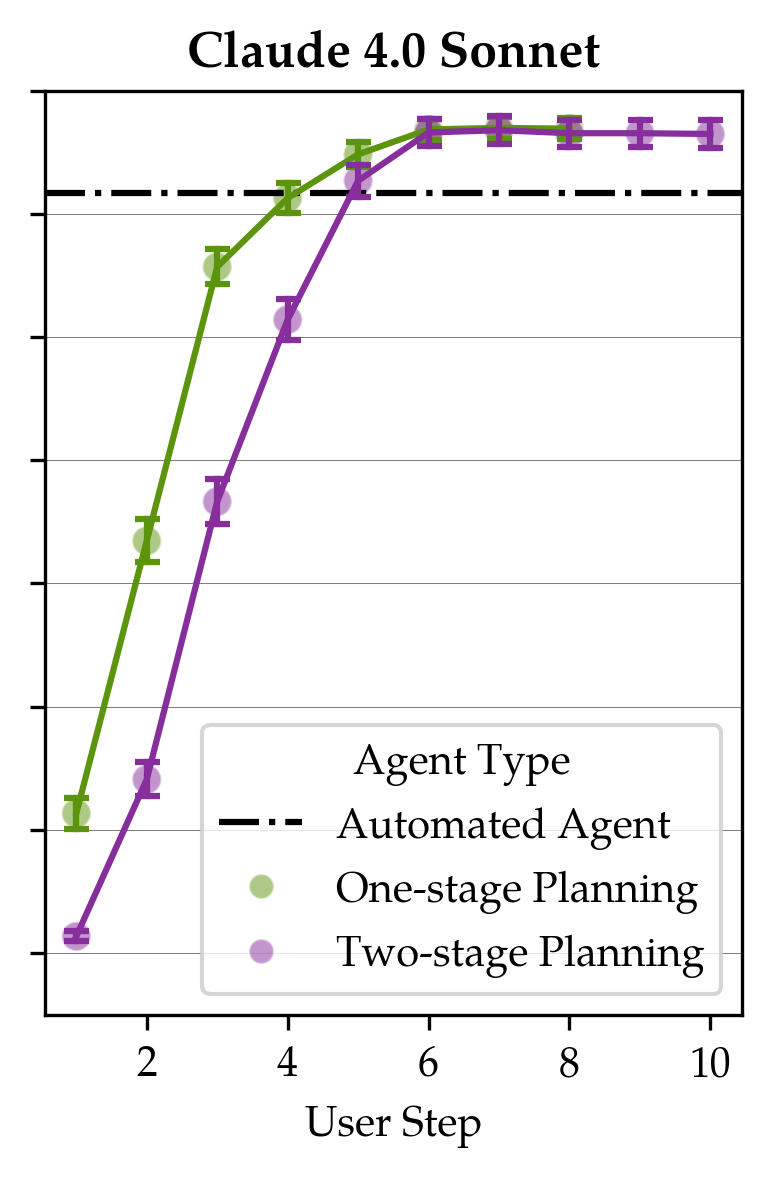

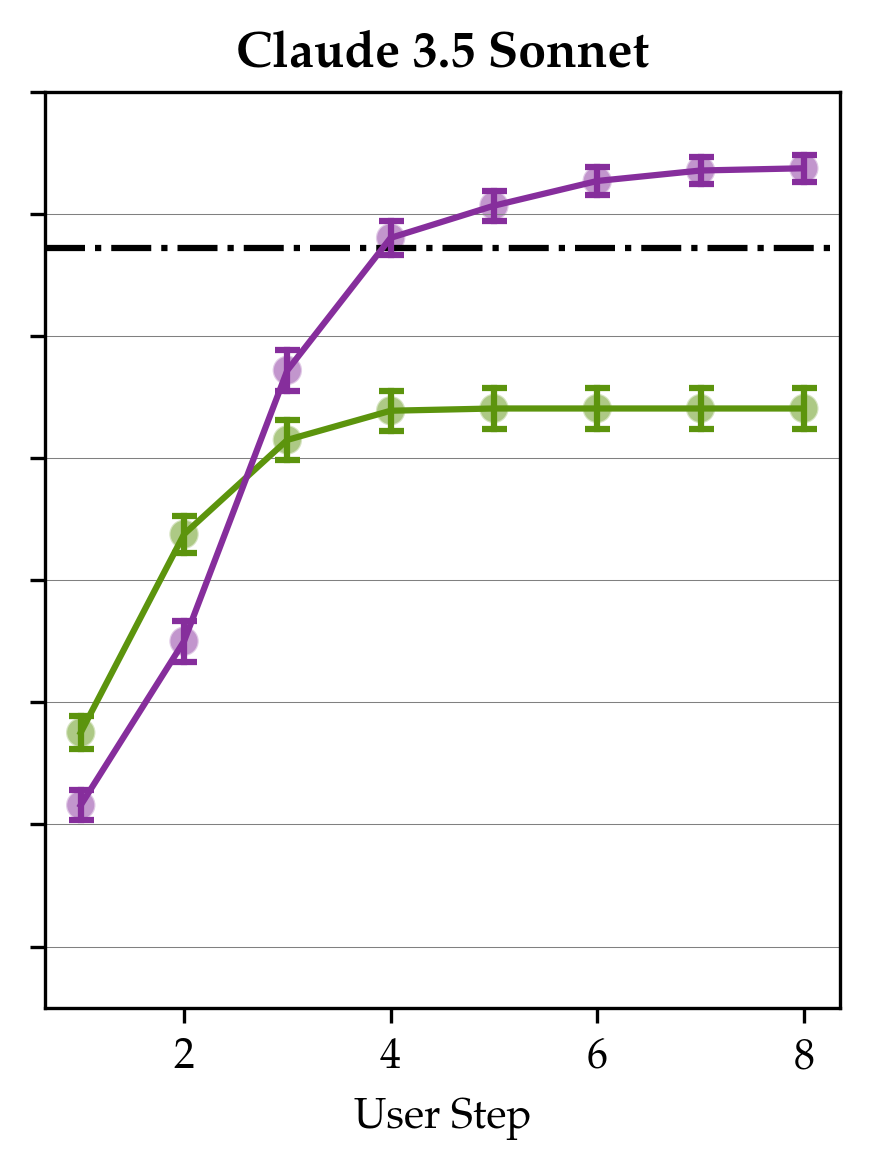

In [8]:
# Load data for both agent implementations
def load_and_prepare_data(agent_type, experiment_path):
    """Load and prepare data for a specific agent type"""
    eval_data = load_agent_process_eval(
        experiment_path,
        fill_empty_interactions=True,
        pad_trajectories=True,
        truncate_trajectories=True,
    )
    
    eval_data = pd.concat(eval_data)
    eval_data['user_step'] = eval_data['user_step'] + 1
    eval_data['agent_type'] = agent_type  # Add agent type as a column
    
    return eval_data

# Load data for both agent implementations
base_data = load_and_prepare_data("Base Agent", "final_results/travel_planning_one")
collab_data = load_and_prepare_data("Collaborative Agent", "final_results/travel_planning_two")


auto_data = load_task_final_performance("final_results/travel_planning_auto", ["gpt4o.bug", "gpt4turbo.bug"])
auto_data = pd.DataFrame(auto_data).drop(columns=["parsed_travel_plan", "commonsense_evaluation", "travel_plan", 
"outcome"])
auto_data = auto_data.groupby(["model_name"])[["commonsense_pass_rate","preference_pass_rate","performance_rating"]].mean().reset_index()


# Combine the data
combined_data = pd.concat([base_data, collab_data])

# Define color scheme for agent types
agent_color_dict = {
    # "Collaborative Agent": "#1f77b4",
    # "Base Agent": "#37B24D",
    "Collaborative Agent": "#862E9C",
    "Base Agent": "#5C940D",
    "Auto Agent": "black"
}

label2text = {
    "Base Agent": r"One-stage Planning",
    "Collaborative Agent": r"Two-stage Planning",
    "Auto Agent": r"Automated Agent"
}

# Get unique models
# models = combined_data['model_name'].unique()
models = ["claude40", "claude3sonnet"]
model_name_dict = {
    "claude40": "Claude 4.0 Sonnet",
    "claude3sonnet": "Claude 3.5 Sonnet"
}

# Create a figure with subplots - one per model
# fig, axes = plt.subplots(1, len(models), figsize=(3*len(models), 4), dpi=300)

plt.figure(figsize=(3,4), dpi=300)

# Process each model
for i, model in enumerate(models):
    plt.figure(figsize=(3,4), dpi=300)
    ax = plt.subplot()
    model_data = combined_data[combined_data['model_name'] == model]
    
    # Calculate session counts for sizing the scatter plots
    session_count = model_data.groupby(["agent_type", "user_step"]).size().to_frame().reset_index().rename(columns={0: "Session Count"})
    
    # Basic plot setup
    ax.grid(axis='y', color='0.5', linewidth=0.25)
    

    # Plot the auto data
    ax.axhline(
        y=auto_data.loc[auto_data['model_name'] == model, 'performance_rating'].values[0],
        color='black',
        linestyle='-.',
        label='Auto Agent'
    )
    # Plot line graph with error bars
    sns.lineplot(
        data=model_data,
        x="user_step",
        y="performance_rating",
        err_style="bars", 
        errorbar=("se", 0.5),
        legend=False,
        ax=ax,
        hue="agent_type",
        palette=agent_color_dict,
        err_kws={
            'linewidth': 1.5,
            'capsize': 3,
            'capthick': 1.5
        }
    )
    
    # Prepare data for scatter plot
    plot_df2 = model_data.groupby(["user_step", "agent_type"]).agg({"performance_rating": "mean"}).reset_index().merge(session_count)
    
    # Add scatter plot
    sns.scatterplot(
        data=plot_df2,
        x="user_step",
        y="performance_rating",
        hue="agent_type",
        size="Session Count",
        sizes=(50, 200),
        size_order=[50, 100, 200],
        alpha=0.5,
        palette=agent_color_dict,
        ax=ax,
    )
    
    # Set axis labels and limits
    ax.set_ylim(-0.05, 0.70)
    # ax.set_xlim(0.75, 12)
    ax.set_ylabel(r"Performance Rating")
    ax.set_xlabel(r"User Step")
    
    # Set title with model name
    ax.set_title(f"{model}", fontproperties=texgyrepagella_bold, fontsize=12)
    

    # Only show legend on the first plot
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        # Filter to only include agent_type entries (not sizes)
        unique_labels = []
        unique_handles = []
        for handle, label in zip(handles, labels):
            if label in agent_color_dict and label not in unique_labels:
                unique_labels.append(label2text[label])
                unique_handles.append(handle)
        ax.legend(unique_handles, unique_labels, loc="lower right", title="Agent Type")
    else:
        ax.get_legend().remove()
        ax.set_ylabel("")
        ax.yaxis.set_ticklabels([])
    
    ax.set_ylabel("")
    ax.yaxis.set_ticklabels([])
    ax.set_title(model_name_dict[model], fontproperties=texgyrepagella_bold, fontsize=12)



   
plt.tight_layout()
# plt.savefig("model_comparison_by_agent_type.png", bbox_inches="tight")
plt.show()

Text(0.5, 1.0, 'Two-stage Collaboration Planning Agents')

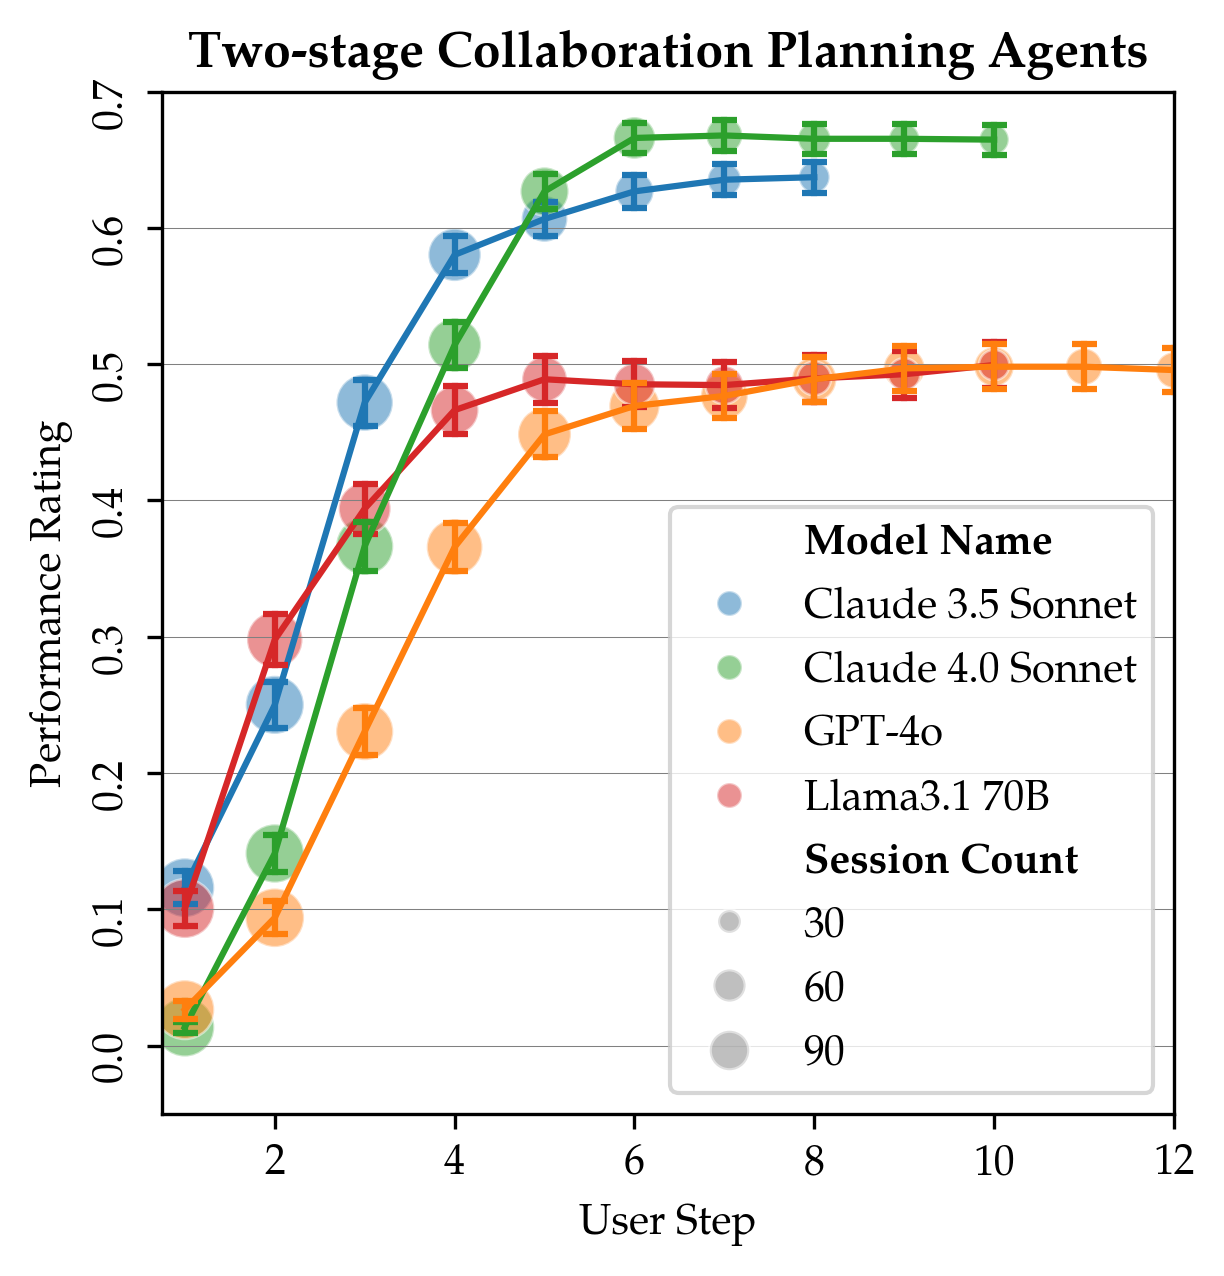

In [9]:
eval_data_original = load_agent_process_eval(
    "final_results/travel_planning_two",
    fill_empty_interactions = True,
    pad_trajectories = False, 
    truncate_trajectories = False,
)

eval_data_plot = load_agent_process_eval(
    "final_results/travel_planning_two",
    fill_empty_interactions = True,
    pad_trajectories = True, 
    truncate_trajectories = True,
)


eval_data_original = pd.concat(eval_data_original)
eval_data_original['user_step'] = eval_data_original['user_step'] + 1
eval_data_original['model_name'] = eval_data_original['model_name'].map({
    "claude3sonnet": "Claude 3.5 Sonnet",
    "gpt4o": "GPT-4o",
    "gpt4turbo": "GPT-4 Turbo",
    "claude40": "Claude 4.0 Sonnet",
    "llama3-70b": "Llama3.1 70B"
})

eval_data_plot = pd.concat(eval_data_plot)
eval_data_plot['user_step'] = eval_data_plot['user_step'] + 1
eval_data_plot['model_name'] = eval_data_plot['model_name'].map({
    "claude3sonnet": "Claude 3.5 Sonnet",
    "gpt4o": "GPT-4o",
    "gpt4turbo": "GPT-4 Turbo",
    "claude40": "Claude 4.0 Sonnet",
    "llama3-70b": "Llama3.1 70B"
})

session_count = eval_data_original.groupby(["model_name", "user_step"]).size().to_frame().reset_index().rename(columns={0: "Session Count"})
session_count.model_name.unique()

color_dict = {
    "Claude 3.5 Sonnet": "#1f77b4",  # Replace with your actual model names and desired colors
    "GPT-4o": "#ff7f0e",
    "GPT-4 Turbo": "#2ca02c",
    "Claude 4.0 Sonnet": "#2ca02c",
    "Llama3.1 70B": "#d62728"
}

plt.figure(figsize=(4,4), dpi=300)
ax = plt.subplot()

plt.grid(axis='y', color='0.5', linewidth=0.25)
plt.yticks(rotation=90)
plt.tight_layout()

tmp = eval_data_plot.rename(columns={"model_name": "Model Name"})
ax = sns.lineplot(
    data=tmp[tmp["Model Name"] != "GPT-4 Turbo"],
    x="user_step",
    y="performance_rating",
    err_style="bars", 
    errorbar=("se", 0.5),
    # style="Model Name",
    # markers=True, dashes=False,
    # units="session_name",
    # estimator=None,
    # lw=1,
    # alpha=0.5,
    legend=False,
    ax=ax,
    hue="Model Name",
    palette=color_dict,
    err_kws={
        # 'alpha': 0.3,        # Transparency of error bands/bars
        'linewidth': 1.5,    # Width of error bar lines (if using 'bars')
        'capsize': 3,        # Size of error bar caps (if using 'bars')
        'capthick': 1.5        # Thickness of caps (if using 'bars')
    }
)

plot_df2 = eval_data_plot.groupby(["user_step", "model_name"]).agg({"performance_rating": "mean"}).reset_index().merge(session_count)

ax = sns.scatterplot(
    data=plot_df2[plot_df2["model_name"] != "GPT-4 Turbo"].rename(columns={"model_name": "Model Name"}),
    x="user_step",
    y="performance_rating",
    hue="Model Name",
    size="Session Count",
    # markers=True, dashes=False,
    sizes = (50, 200),
    size_order = [50, 100, 200],
    alpha=0.5,
    # legend=False,
    palette=color_dict,
    ax=ax,
)

# Get current legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Find where "Session Count" title appears in labels
size_title_idx = labels.index("Session Count")

# Keep hue legend items (before size title) and modify size items
hue_handles = handles[:size_title_idx]
hue_labels = labels[:size_title_idx]

# Create new legend with custom size values
# You'll need to manually create size handles for 30, 60, 90
from matplotlib.lines import Line2D

# Custom size legend entries
size_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=np.sqrt(30), alpha=0.5, linestyle=''),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=np.sqrt(60), alpha=0.5, linestyle=''),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=np.sqrt(90), alpha=0.5, linestyle=''),
]
size_labels = ['30', '60', '90']

# Combine all handles and labels
all_handles = hue_handles + [Line2D([0], [0], visible=False)] + size_handles
all_labels = hue_labels + ['Session Count'] + size_labels

# font_path = 'fonts/texgyrepagella-bold.otf' 
# texgyrepagella_bold = font_manager.FontProperties(fname=font_path, weight='bold')


ax.legend(handles=all_handles, labels=all_labels, 
          loc='best', frameon=True)  # Use your custom bold font)

legend = ax.get_legend()
texts = legend.get_texts()

# Bold all titles - the titles are typically the first items before the actual labels
for text in texts:
    # Check if it's likely a title (you can also check by content)
    if text.get_text() in ["Model Name", "Session Count"]:
        text.set_fontweight('bold')

ax.set_ylabel(r"Performance Rating")
ax.set_xlabel(r"User Step")
ax.set_ylim(-0.05, 0.70)
ax.set_xlim(0.75, 12)
plt.title(r"Two-stage Collaboration Planning Agents", fontproperties=texgyrepagella_bold, fontsize=12)
# plt.legend(loc="lower right", prop={'size': 4})

### Effort Distribution 

In [10]:
import json 

def read_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)


def load_agent_status_info(results_folder, include_simulated_user=True, agent_folder_name="basic_collaborative_agent"):
    """
    Load agent status information from a results folder.
    
    Args:
        results_folder: Path to the results folder (e.g., 'final_results/travel_planning_two_stage_co_agent_claude40/results')
        include_simulated_user: Whether to include simulated user info (default: True)
    
    Returns:
        pandas.DataFrame with columns: env, agent_lm, agent_prompt_tokens, agent_completion_tokens,
                                       sim_user_lm, sim_user_prompt_tokens, sim_user_completion_tokens,
                                       performance_rating
    """
    import os
    import pandas as pd
    
    results = []
    
    # Iterate through all env folders
    for env_folder in sorted(os.listdir(results_folder)):
        if not env_folder.startswith('env_'):
            continue
            
        env_path = os.path.join(results_folder, env_folder)
        if not os.path.isdir(env_path):
            continue
        
        # Load agent info
        agent_info_path = os.path.join(env_path, agent_folder_name, 'info.json')
        if not os.path.exists(agent_info_path):
            continue
            
        try:
            agent_info = read_json(agent_info_path)
        except:
            print(f"Error loading agent info from {agent_info_path}")
            continue
        
        row = {
            'env': env_folder,
            'agent_lm': agent_info.get('lm', ''),
            'agent_prompt_tokens': agent_info.get('token_usage', {}).get('prompt_tokens', 0),
            'agent_completion_tokens': agent_info.get('token_usage', {}).get('completion_tokens', 0)
        }
        
        # Load simulated user info if requested
        if include_simulated_user:
            sim_user_info_path = os.path.join(env_path, 'simulated_user', 'info.json')
            if os.path.exists(sim_user_info_path):
                sim_user_info = read_json(sim_user_info_path)
                
                # Assuming planning_lm and executing_lm are the same
                row['sim_user_lm'] = sim_user_info.get('planning_lm', '')
                
                # Sum up tokens from planning and executing LMs
                token_usage = sim_user_info.get('token_usage', {})
                if 'planning_lm' in token_usage:
                    planning_tokens = token_usage.get('planning_lm', {})
                    executing_tokens = token_usage.get('executing_lm', {})
                    
                    row['sim_user_prompt_tokens'] = (
                        planning_tokens.get('prompt_tokens', 0) + 
                        executing_tokens.get('prompt_tokens', 0)
                    )
                    row['sim_user_completion_tokens'] = (
                        planning_tokens.get('completion_tokens', 0) + 
                        executing_tokens.get('completion_tokens', 0)
                    )
                else:
                    row['sim_user_prompt_tokens'] = token_usage.get('prompt_tokens', 0)
                    row['sim_user_completion_tokens'] = token_usage.get('completion_tokens', 0)

            else:
                row['sim_user_lm'] = None
                row['sim_user_prompt_tokens'] = 0
                row['sim_user_completion_tokens'] = 0
        
        # Load task performance info
        task_performance_path = os.path.join(env_path, 'task_performance.json')
        if os.path.exists(task_performance_path):
            task_performance = read_json(task_performance_path)
            row['performance_rating'] = task_performance.get('performance_rating', None)
        else:
            row['performance_rating'] = None
        
        results.append(row)
    
    return pd.DataFrame(results)

In [11]:
# Define all experiment paths
experiment_paths = [
    "final_results/travel_planning_two_stage_co_agent_claude40",
    "final_results/travel_planning_two_stage_co_agent_claude3sonnet",
    "final_results/travel_planning_two_stage_co_agent_gpt4o",
    "final_results/travel_planning_two_stage_co_agent_llama3-70b",
    "final_results/travel_planning_one_stage_co_agent_gpt4o",
    "final_results/travel_planning_one_stage_co_agent_claude40",
    "final_results/travel_planning_one_stage_co_agent_llama3-70b",
    "final_results/travel_planning_one_stage_co_agent_claude3sonnet",
]


model_name_mapping = {
    "claude3sonnet": "Claude 3.5 Sonnet",
    "claude40": "Claude 4.0 Sonnet",
    "gpt4o": "GPT-4o",
    "llama3-70b": "Llama3.1 70B"
}

setup_name_mapping = {
    "two_stage_co_agent": "Two-stage Collaboration",
    "one_stage_co_agent": "One-stage Collaboration",
    "auto_agent": "Automated Agent"
}

# Load data from all experiments
all_dfs = []
for exp_path in experiment_paths:
    results_path = os.path.join(exp_path, "results")
    if os.path.exists(results_path):
        
        
        # Extract setup and model from path
        # e.g., "travel_planning_two_stage_co_agent_claude40" -> setup="two_stage_co_agent", model="claude40"
        exp_name = exp_path.split('/')[-1]  # Get last part of path
        parts = exp_name.replace('travel_planning_', '').rsplit('_', 1)
        if len(parts) == 2:
            setup = parts[0]
            model = parts[1]
        else:
            setup = exp_name
            model = 'unknown'
        
        if setup == "auto_agent":
            agent_folder_name = "basic_auto_agent"
        else:
            agent_folder_name = "basic_collaborative_agent"
        df_temp = load_agent_status_info(results_path, agent_folder_name=agent_folder_name)

        # print(parts)
        # print(len(df_temp))
        df_temp['setup'] = setup_name_mapping[setup]
        df_temp['model'] = model_name_mapping[model]
        
        all_dfs.append(df_temp)

# Combine all dataframes
df = pd.concat(all_dfs, ignore_index=True)
df

,env,agent_lm,agent_prompt_tokens,agent_completion_tokens,sim_user_lm,sim_user_prompt_tokens,sim_user_completion_tokens,performance_rating,setup,model
0,env_travel_planning_0,vertex_ai/claude-sonnet-4@20250514,74405,4015,gpt-4o,15954,337,0.6250,Two-stage Collaboration,Claude 4.0 Sonnet
1,env_travel_planning_1,vertex_ai/claude-sonnet-4@20250514,241524,15605,gpt-4o,71955,1502,0.6250,Two-stage Collaboration,Claude 4.0 Sonnet
2,env_travel_planning_10,vertex_ai/claude-sonnet-4@20250514,165573,7600,gpt-4o,24000,503,0.8750,Two-stage Collaboration,Claude 4.0 Sonnet
3,env_travel_planning_100,vertex_ai/claude-sonnet-4@20250514,168277,14739,gpt-4o,23833,523,0.8750,Two-stage Collaboration,Claude 4.0 Sonnet
4,env_travel_planning_101,vertex_ai/claude-sonnet-4@20250514,91930,4761,gpt-4o,23735,562,0.4375,Two-stage Collaboration,Claude 4.0 Sonnet
...,...,...,...,...,...,...,...,...,...,...
810,env_travel_planning_95,claude-3-5-sonnet-20241022,3457,261,gpt-4o-2024-08-06,265858,10312,0.0000,One-stage Collaboration,Claude 3.5 Sonnet
811,env_travel_planning_96,claude-3-5-sonnet-20241022,66506,4372,gpt-4o-2024-08-06,16146,485,0.6875,One-stage Collaboration,Claude 3.5 Sonnet
812,env_travel_planning_97,claude-3-5-sonnet-20241022,38131,3011,gpt-4o-2024-08-06,28173,934,0.6250,One-stage Collaboration,Claude 3.5 Sonnet
813,env_travel_planning_98,claude-3-5-sonnet-20241022,187696,10526,gpt-4o-2024-08-06,23484,666,0.8750,One-stage Collaboration,Claude 3.5 Sonnet


In [12]:
plotting_df = df[df['setup'] != "Automated Agent"]
analysis_df = plotting_df.groupby(['model', 'setup'])[['agent_completion_tokens', 'sim_user_completion_tokens', 'performance_rating']].mean()
analysis_df['combined_tokens'] = analysis_df['agent_completion_tokens'] + analysis_df['sim_user_completion_tokens']
analysis_df['model_to_user_ratio'] = analysis_df['agent_completion_tokens'] / analysis_df['sim_user_completion_tokens']
# print(analysis_df.apply(lambda x: round(x, 2)).to_latex())
display(analysis_df)

agent_completion_tokens  \
model             setup                                              
Claude 3.5 Sonnet One-stage Collaboration              4539.960784   
                  Two-stage Collaboration             11424.303922   
Claude 4.0 Sonnet One-stage Collaboration              7719.313725   
                  Two-stage Collaboration             10706.009804   
GPT-4o            One-stage Collaboration              4318.333333   
                  Two-stage Collaboration             10483.287129   
Llama3.1 70B      One-stage Collaboration              6067.637255   
                  Two-stage Collaboration              7045.186275   

                                           sim_user_completion_tokens  \
model             setup                                                 
Claude 3.5 Sonnet One-stage Collaboration                 4385.754902   
                  Two-stage Collaboration                 1913.843137   
Claude 4.0 Sonnet One-stage Collaboration                  540.509804   
                  Two-stage Collaboration                  677.745098   
GPT-4o            One-stage Collaboration                 5127.549020   
                  Two-stage Collaboration                 4925.871287   
Llama3.1 70B      One-stage Collaboration                 2921.088235   
                  Two-stage Collaboration                 3599.284314   

                                           performance_rating  \
model             setup                                         
Claude 3.5 Sonnet One-stage Collaboration            0.441789   
                  Two-stage Collaboration            0.641544   
Claude 4.0 Sonnet One-stage Collaboration            0.672794   
                  Two-stage Collaboration            0.664216   
GPT-4o            One-stage Collaboration            0.477941   
                  Two-stage Collaboration            0.495050   
Llama3.1 70B      One-stage Collaboration            0.496324   
                  Two-stage Collaboration            0.498775   

                                           combined_tokens  \
model             setup                                      
Claude 3.5 Sonnet One-stage Collaboration      8925.715686   
                  Two-stage Collaboration     13338.147059   
Claude 4.0 Sonnet One-stage Collaboration      8259.823529   
                  Two-stage Collaboration     11383.754902   
GPT-4o            One-stage Collaboration      9445.882353   
                  Two-stage Collaboration     15409.158416   
Llama3.1 70B      One-stage Collaboration      8988.725490   
                  Two-stage Collaboration     10644.470588   

                                           model_to_user_ratio  
model             setup                                         
Claude 3.5 Sonnet One-stage Collaboration             1.035161  
                  Two-stage Collaboration             5.969300  
Claude 4.0 Sonnet One-stage Collaboration            14.281542  
                  Two-stage Collaboration            15.796514  
GPT-4o            One-stage Collaboration             0.842183  
                  Two-stage Collaboration             2.128210  
Llama3.1 70B      One-stage Collaboration             2.077184  
                  Two-stage Collaboration             1.957385

/var/folders/fk/z8s_ycvd0ngdknd0dg8lg_l80000gn/T/ipykernel_3584/84156289.py:115: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(x_min, x_max)


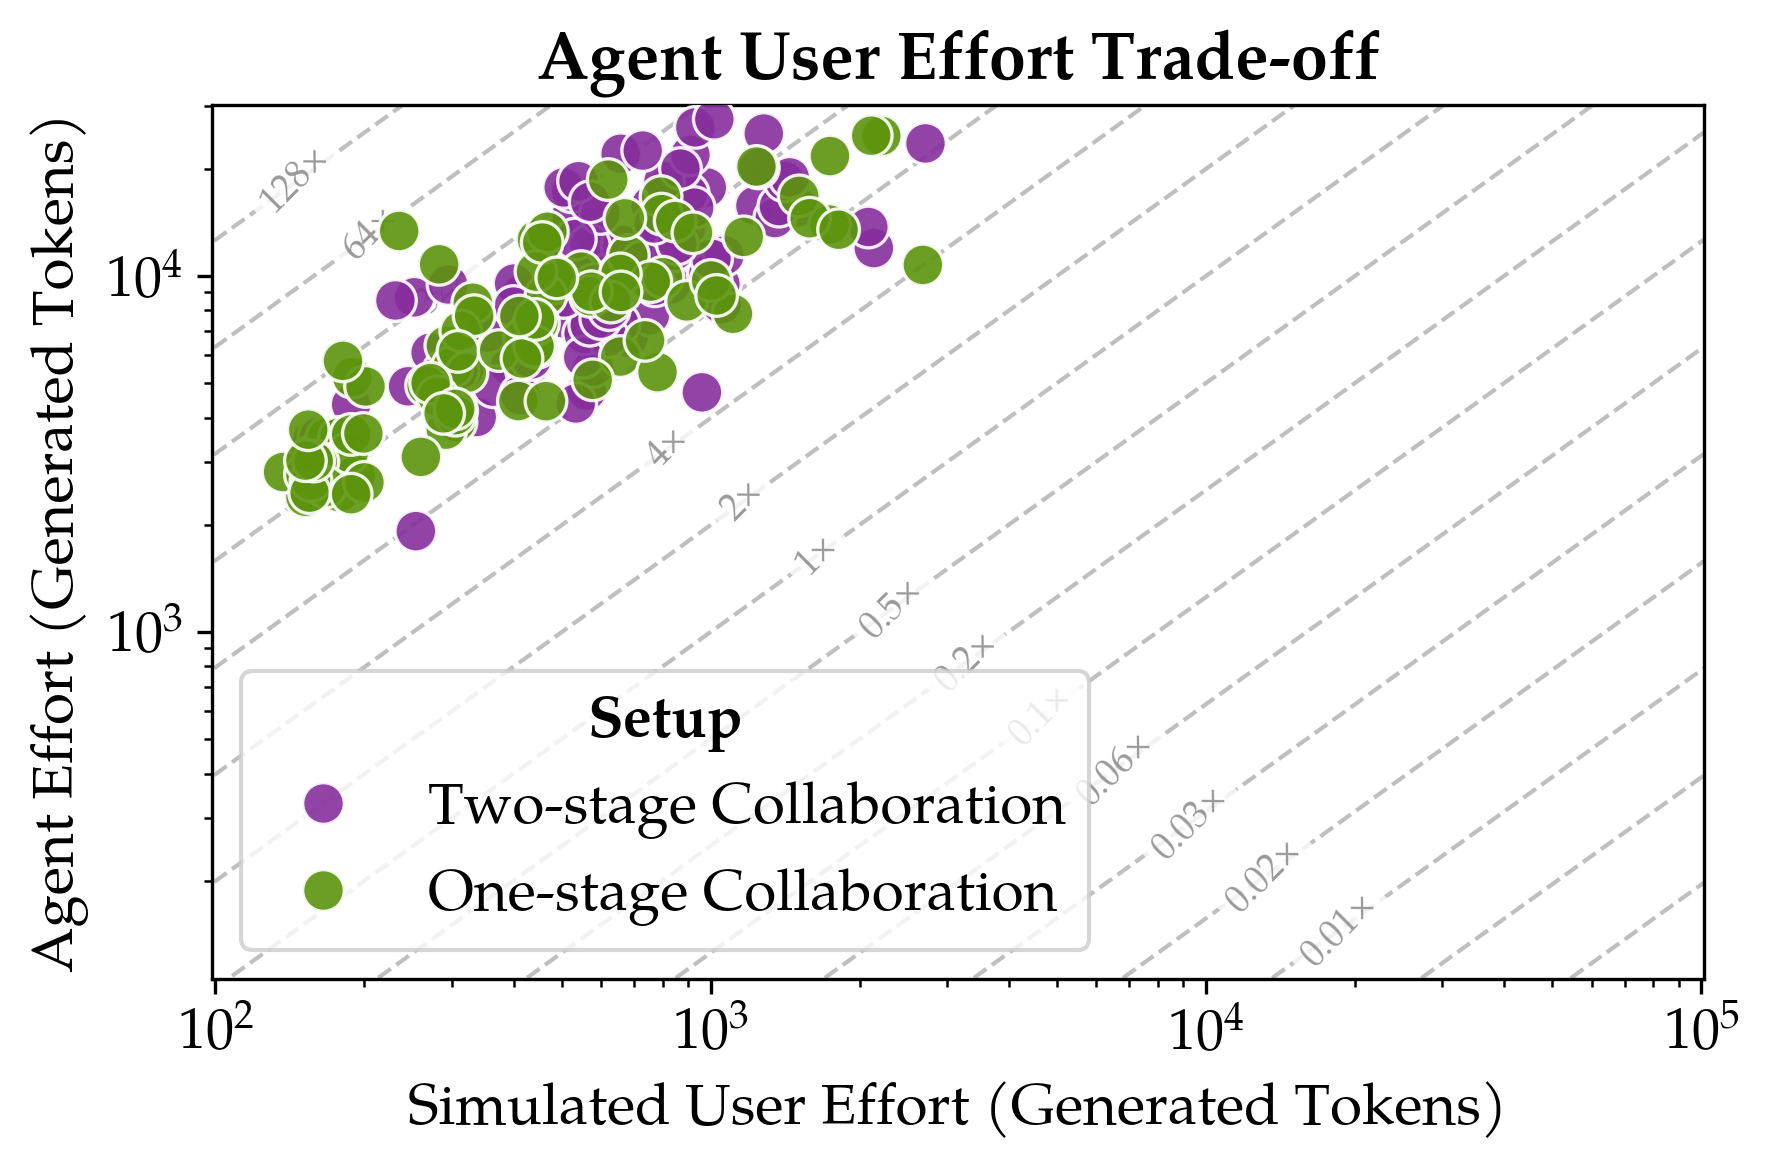

/var/folders/fk/z8s_ycvd0ngdknd0dg8lg_l80000gn/T/ipykernel_3584/84156289.py:115: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(x_min, x_max)


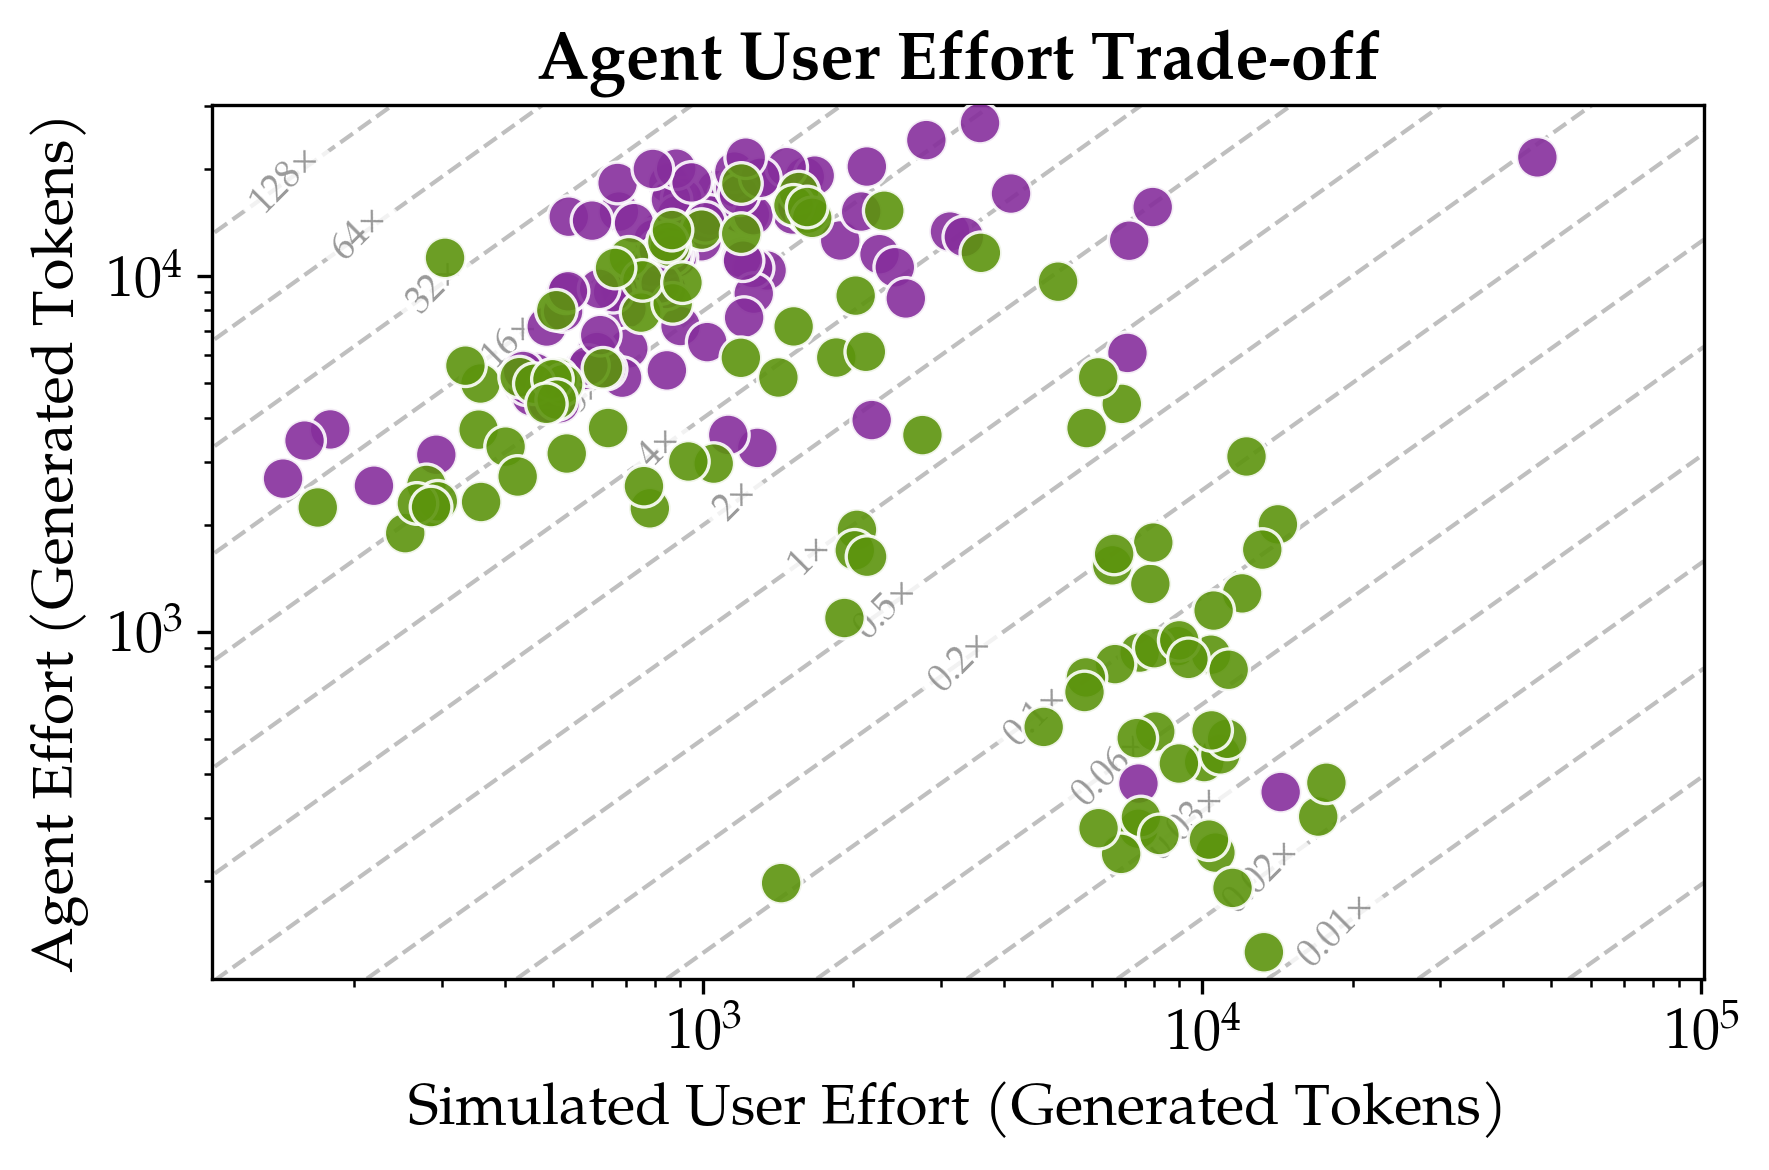

/var/folders/fk/z8s_ycvd0ngdknd0dg8lg_l80000gn/T/ipykernel_3584/84156289.py:115: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(x_min, x_max)


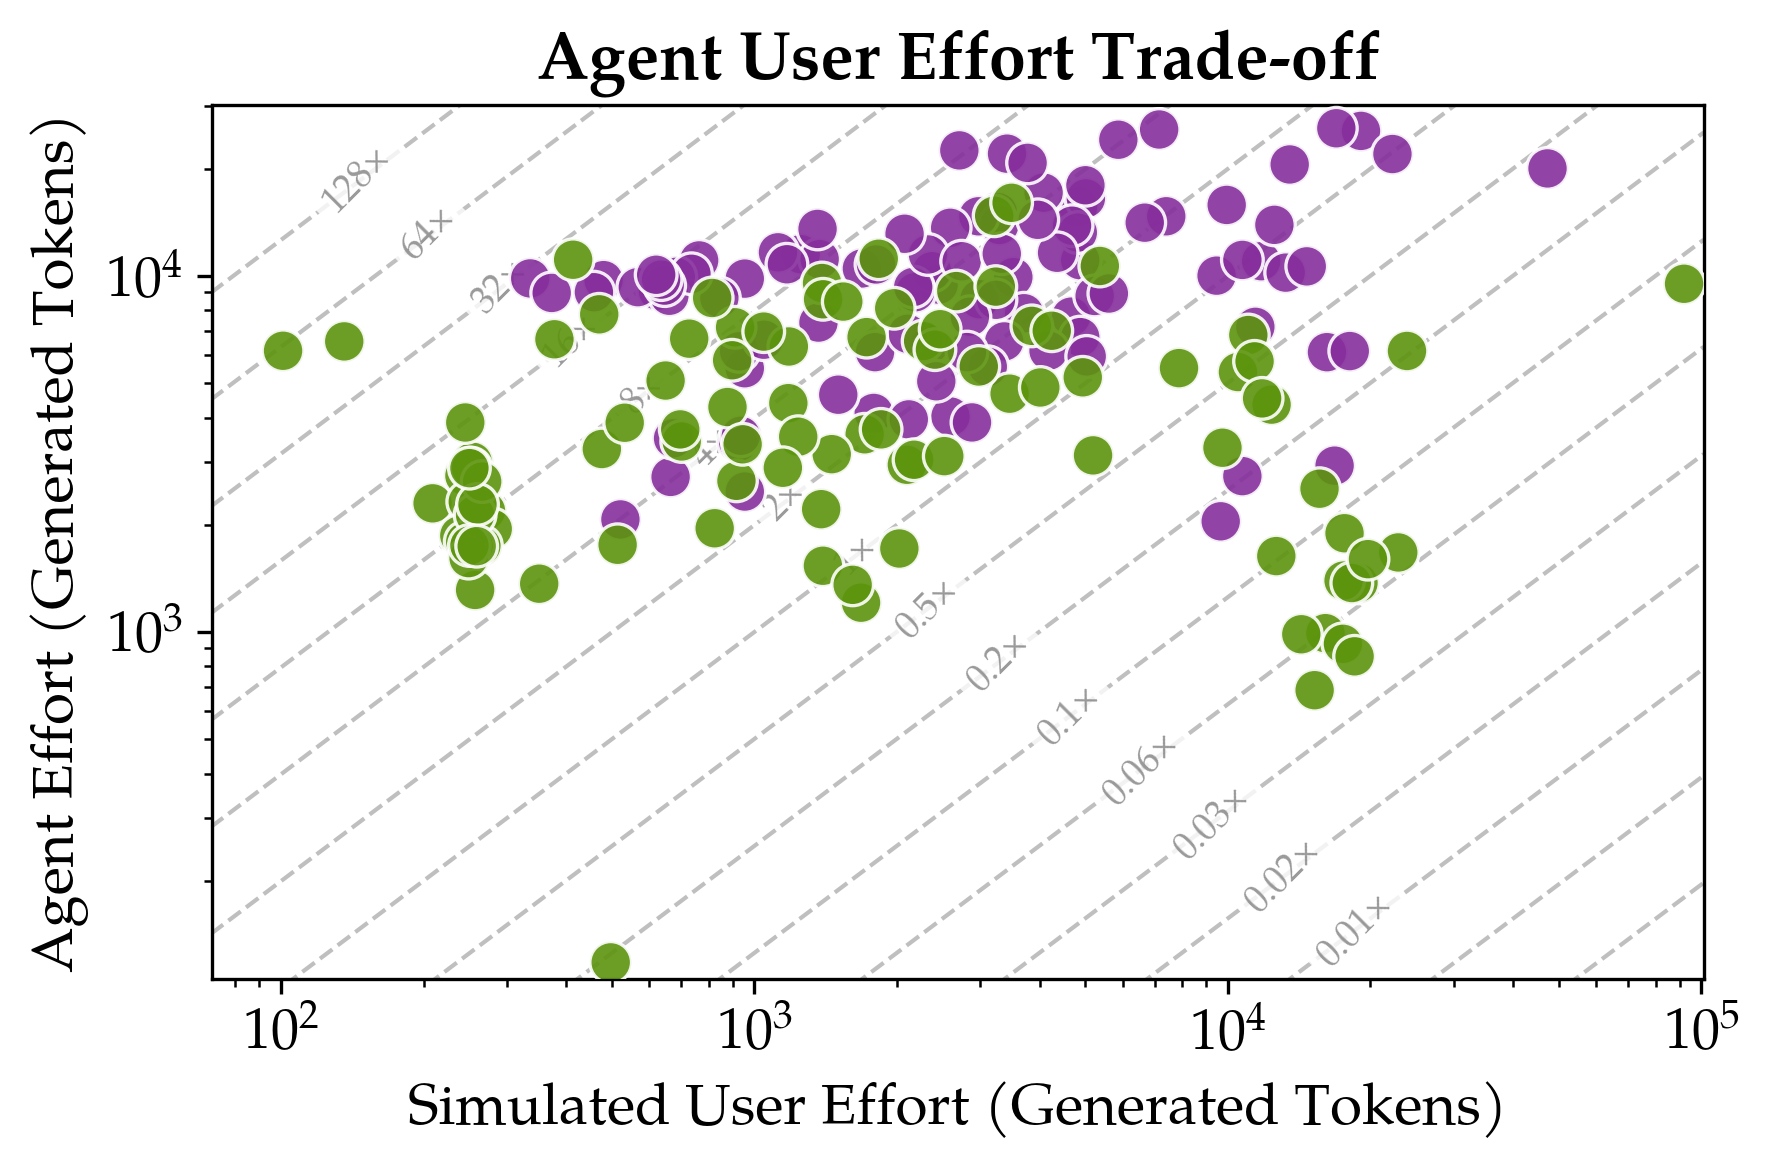

/var/folders/fk/z8s_ycvd0ngdknd0dg8lg_l80000gn/T/ipykernel_3584/84156289.py:115: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(x_min, x_max)


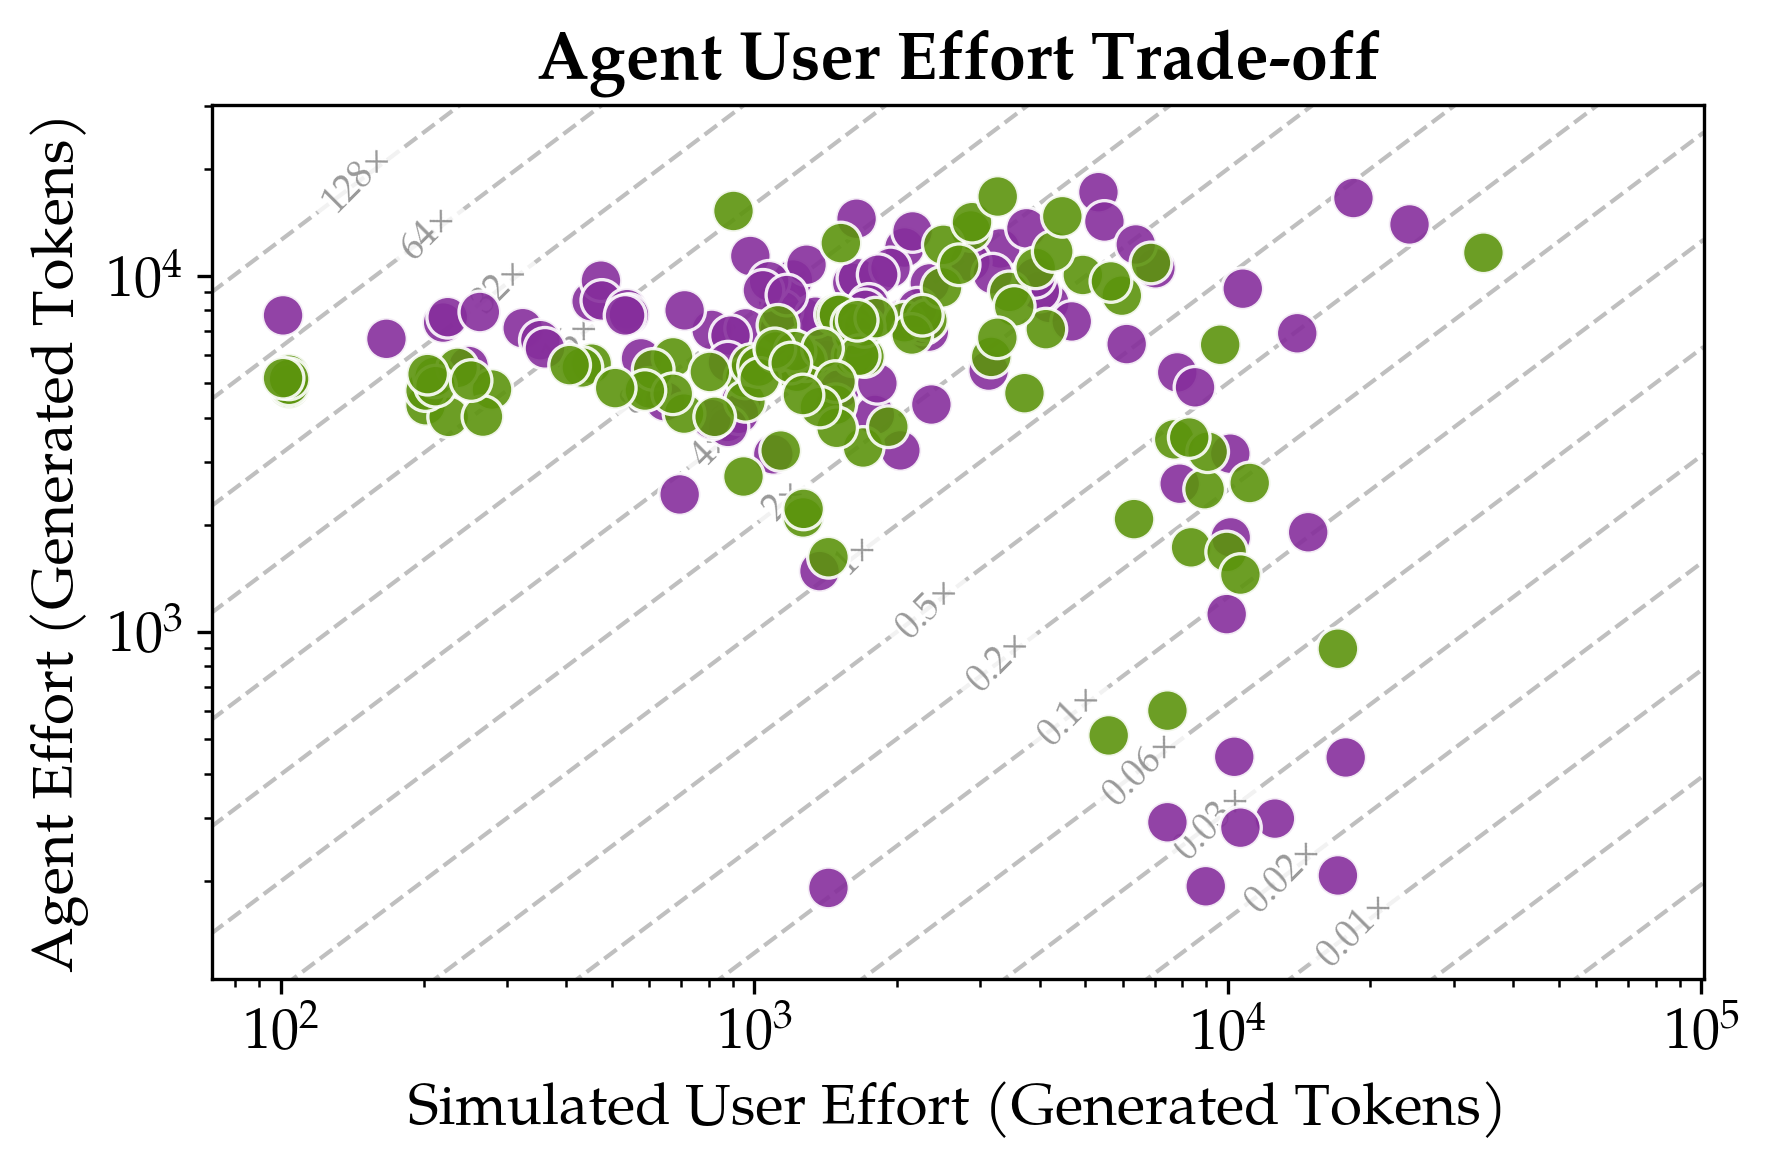

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager

# Load bold font
# texgyrepagella_bold = font_manager.FontProperties(
#     fname='/System/Library/Fonts/Supplemental/Times New Roman Bold.ttf',
#     weight='bold'
# )

# Get unique models
models = plotting_df['model'].unique()

# Define ratio contour values (adjust these as needed)
ratio_values = [0.125/4, 0.125/2, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0]
ratio_values = [2**i for i in range(-10, 8)]

color_dict = {
    "One-stage Collaboration": "#5C940D",
    "Two-stage Collaboration": "#862E9C"
}

# Get global y-axis limits
y_min = plotting_df['agent_completion_tokens'].min()*0.9
y_max = plotting_df['agent_completion_tokens'].max()*1.1
x_min = plotting_df['sim_user_completion_tokens'].min()*0.9
x_minp = max(x_min, 1)
x_max = plotting_df['sim_user_completion_tokens'].max()*1.1

# Create separate plots for each model
for idx, model in enumerate(models):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
    
    model_data = plotting_df[plotting_df['model'] == model]
    # print(model_data.setup.unique())
    
    # Define a constant for label positioning (perpendicular to ratio lines)
    # This creates a diagonal line where x * y = constant
    label_constant = np.sqrt(x_minp * y_max) * 15555.5  # Adjust multiplier for positioning
    
    # Add contour lines for constant ratios first (so they're in the background)
    x_range = np.array([x_min, x_max])
    for ratio in ratio_values:
        y_range = ratio * x_range
        ax.plot(x_range, y_range, 
                linestyle='--', 
                color='gray', 
                alpha=0.5, 
                linewidth=1,
                zorder=1)
        
        # Position label along perpendicular line: x * y = label_constant
        # For each ratio line (y = ratio * x), find intersection with x * y = label_constant
        # ratio * x * x = label_constant => x = sqrt(label_constant / ratio)
        label_x = np.sqrt(label_constant / ratio)
        # print(label_x)
        label_y = ratio * label_x
        
        # Only add label if it's within visible bounds
        if x_min <= label_x <= x_max and y_min <= label_y <= y_max:
            # Format ratio to avoid scientific notation and show appropriate precision
            if ratio < 0.1:
                ratio_text = f'{ratio:.2f}×'
            elif ratio < 1:
                ratio_text = f'{ratio:.1f}×'
            else:
                ratio_text = f'{ratio:.0f}×'
            ax.text(label_x, label_y, ratio_text, 
                    fontsize=9, 
                    color='gray',
                    alpha=0.8,
                    bbox=dict(boxstyle='round,pad=0.3', 
                             facecolor='white', 
                             alpha=0.8,
                             edgecolor='none'),
                    ha='center',
                    va='center',
                    rotation=45,
                    zorder=2)
    
    # Plot scatter points on top
    sns.scatterplot(
        data=model_data, 
        x='sim_user_completion_tokens', 
        y='agent_completion_tokens', 
        hue='setup',
        palette=color_dict,
        ax=ax,
        s=100,  # Make points slightly larger
        alpha=0.9,  # Make points slightly transparent
        zorder=3  # Ensure scatter points are on top
    )
    
    ax.set_xlabel('Simulated User Effort (Generated Tokens)', fontsize=14)
    ax.set_ylabel('Agent Effort (Generated Tokens)', fontsize=14)
    # ax.set_title(f'{model}', fontproperties=texgyrepagella_bold)
    # ax.set_title(f"{model}", fontproperties=texgyrepagella_bold, fontsize=12)
    ax.set_title(f"Agent User Effort Trade-off", fontproperties=texgyrepagella_bold, fontsize=16)
    
    # Set tick label font size
    ax.tick_params(axis='both', which='major', labelsize=13.5)
    
    # Only show legend for the first plot
    if idx == 0:
        legend = ax.legend(title='Setup', fontsize=14)
        legend.set_title('Setup', prop=texgyrepagella_bold)
        legend.get_title().set_fontsize(14)
    else:
        ax.legend().set_visible(False)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(x_min, x_max)
    # ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

### Distribution Plots 

In [14]:
plotting_df['model_to_user_ratio'] = plotting_df['agent_completion_tokens'] / plotting_df['sim_user_completion_tokens']

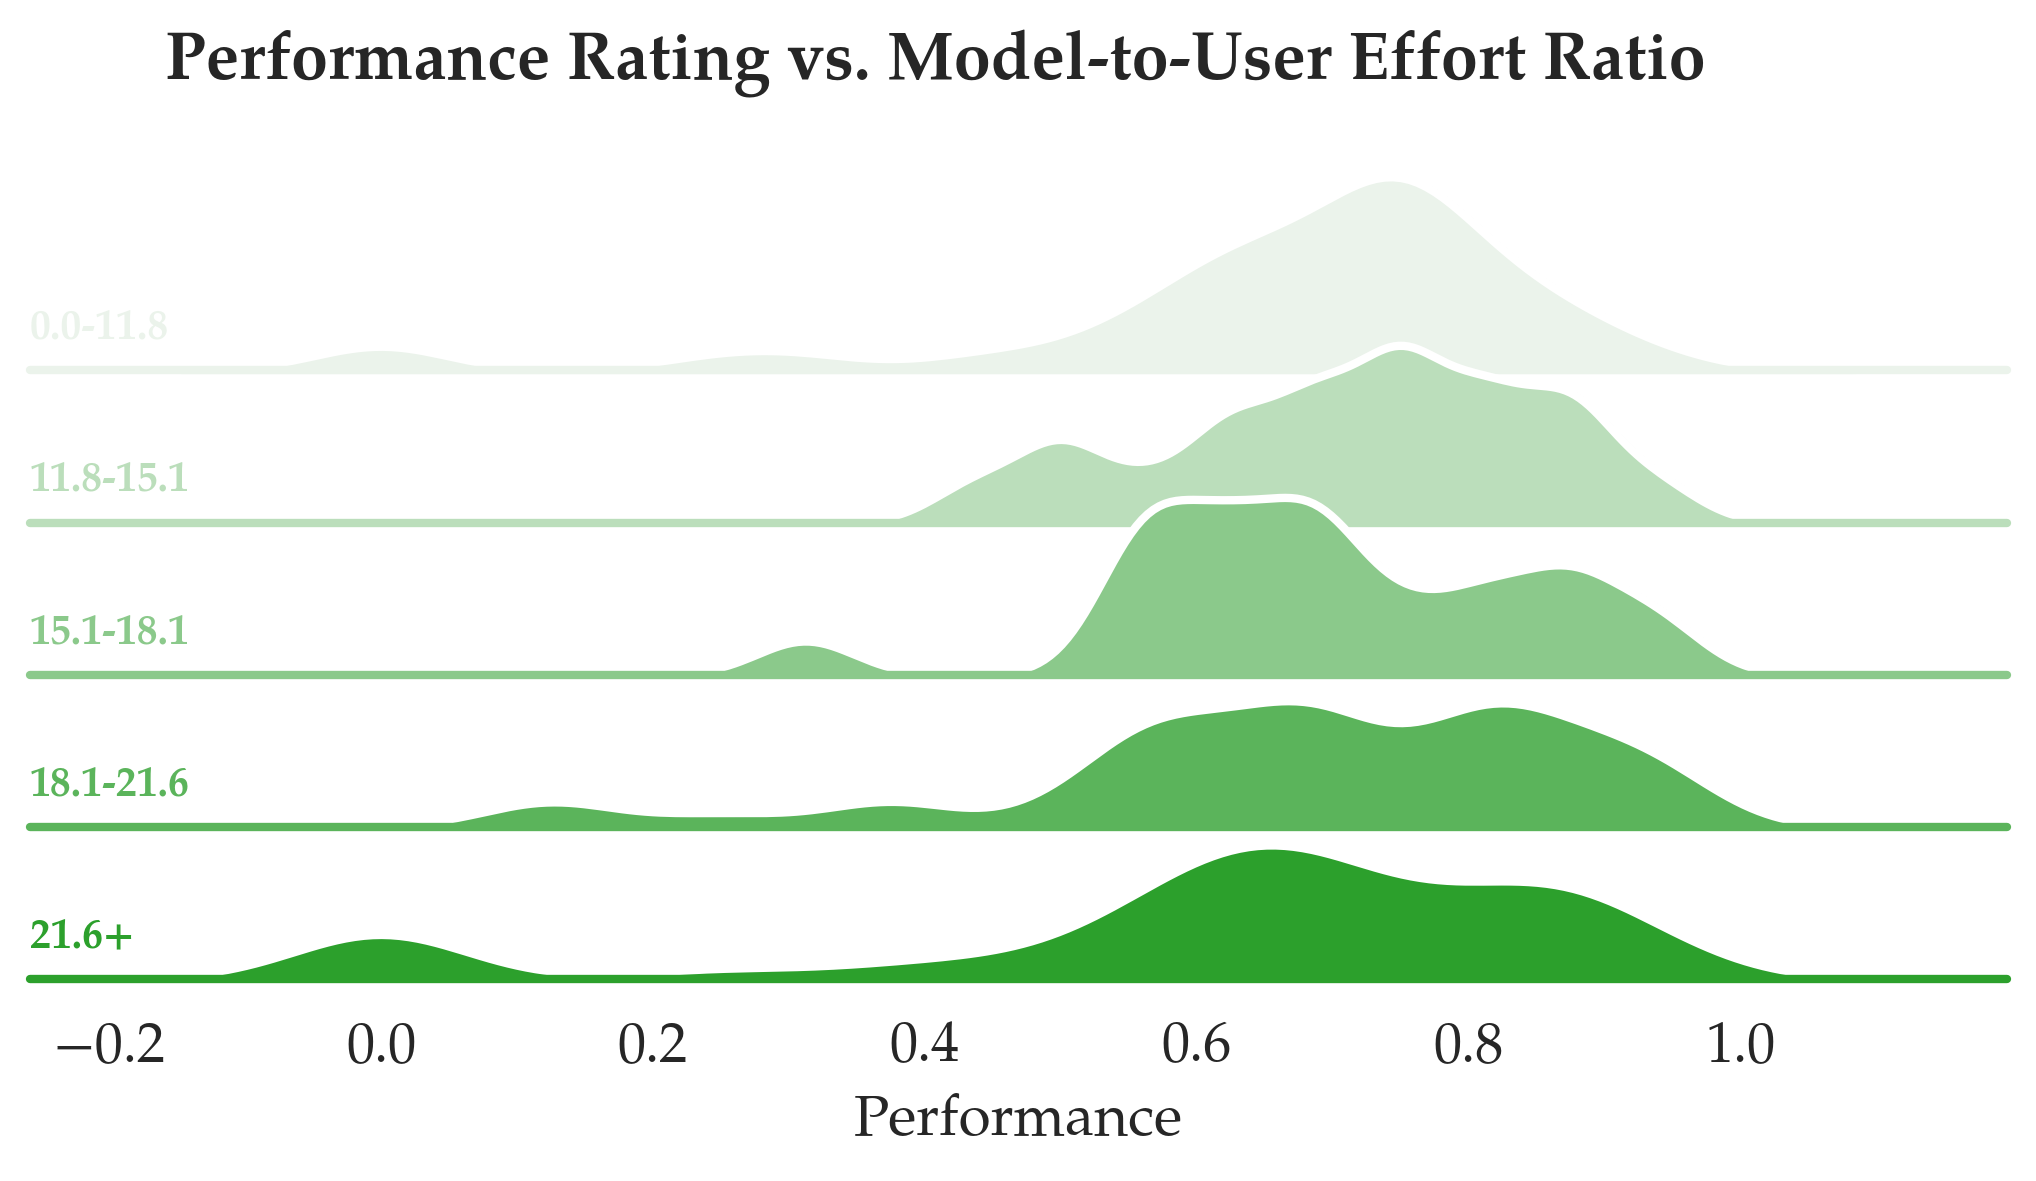

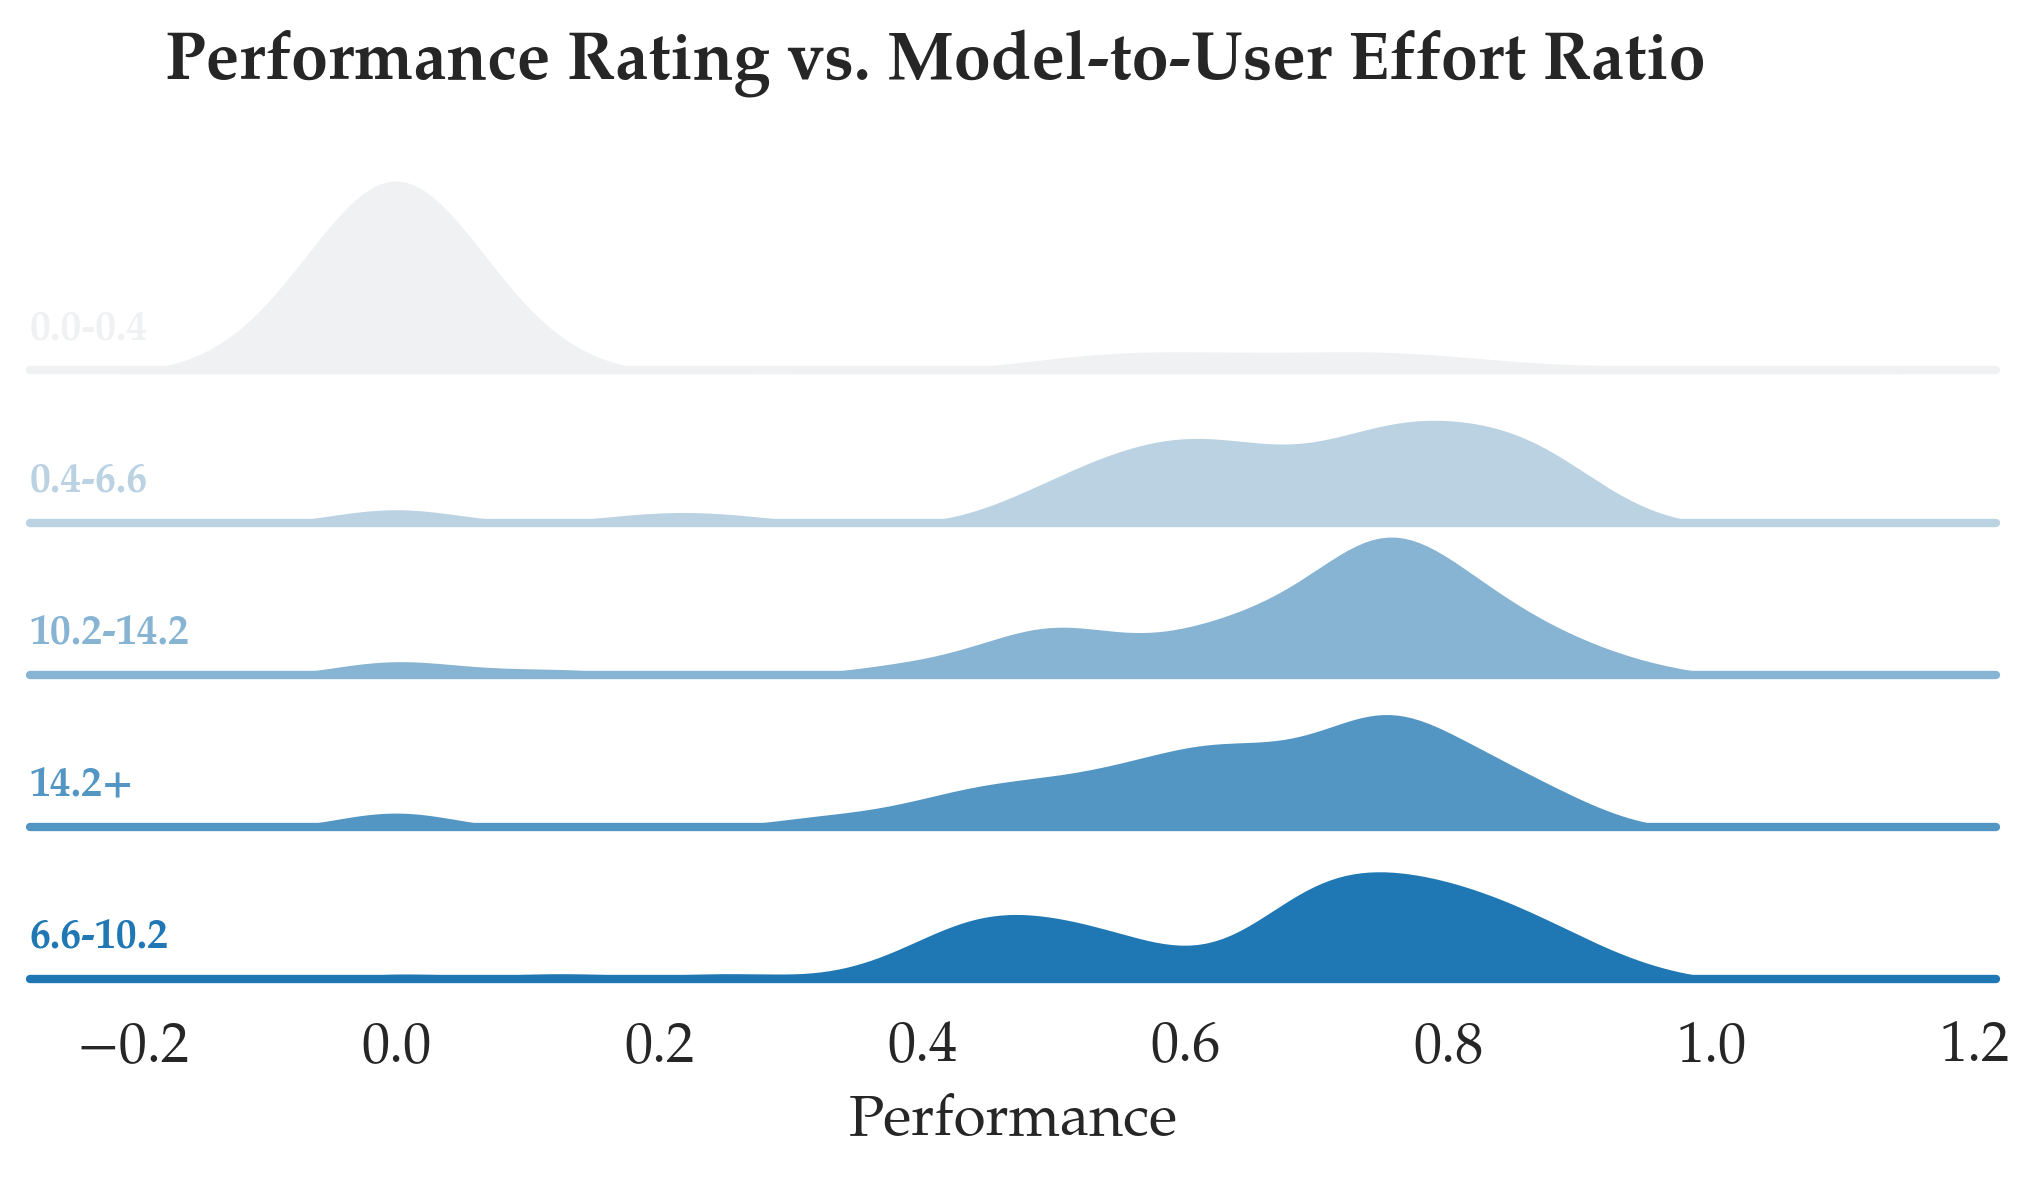

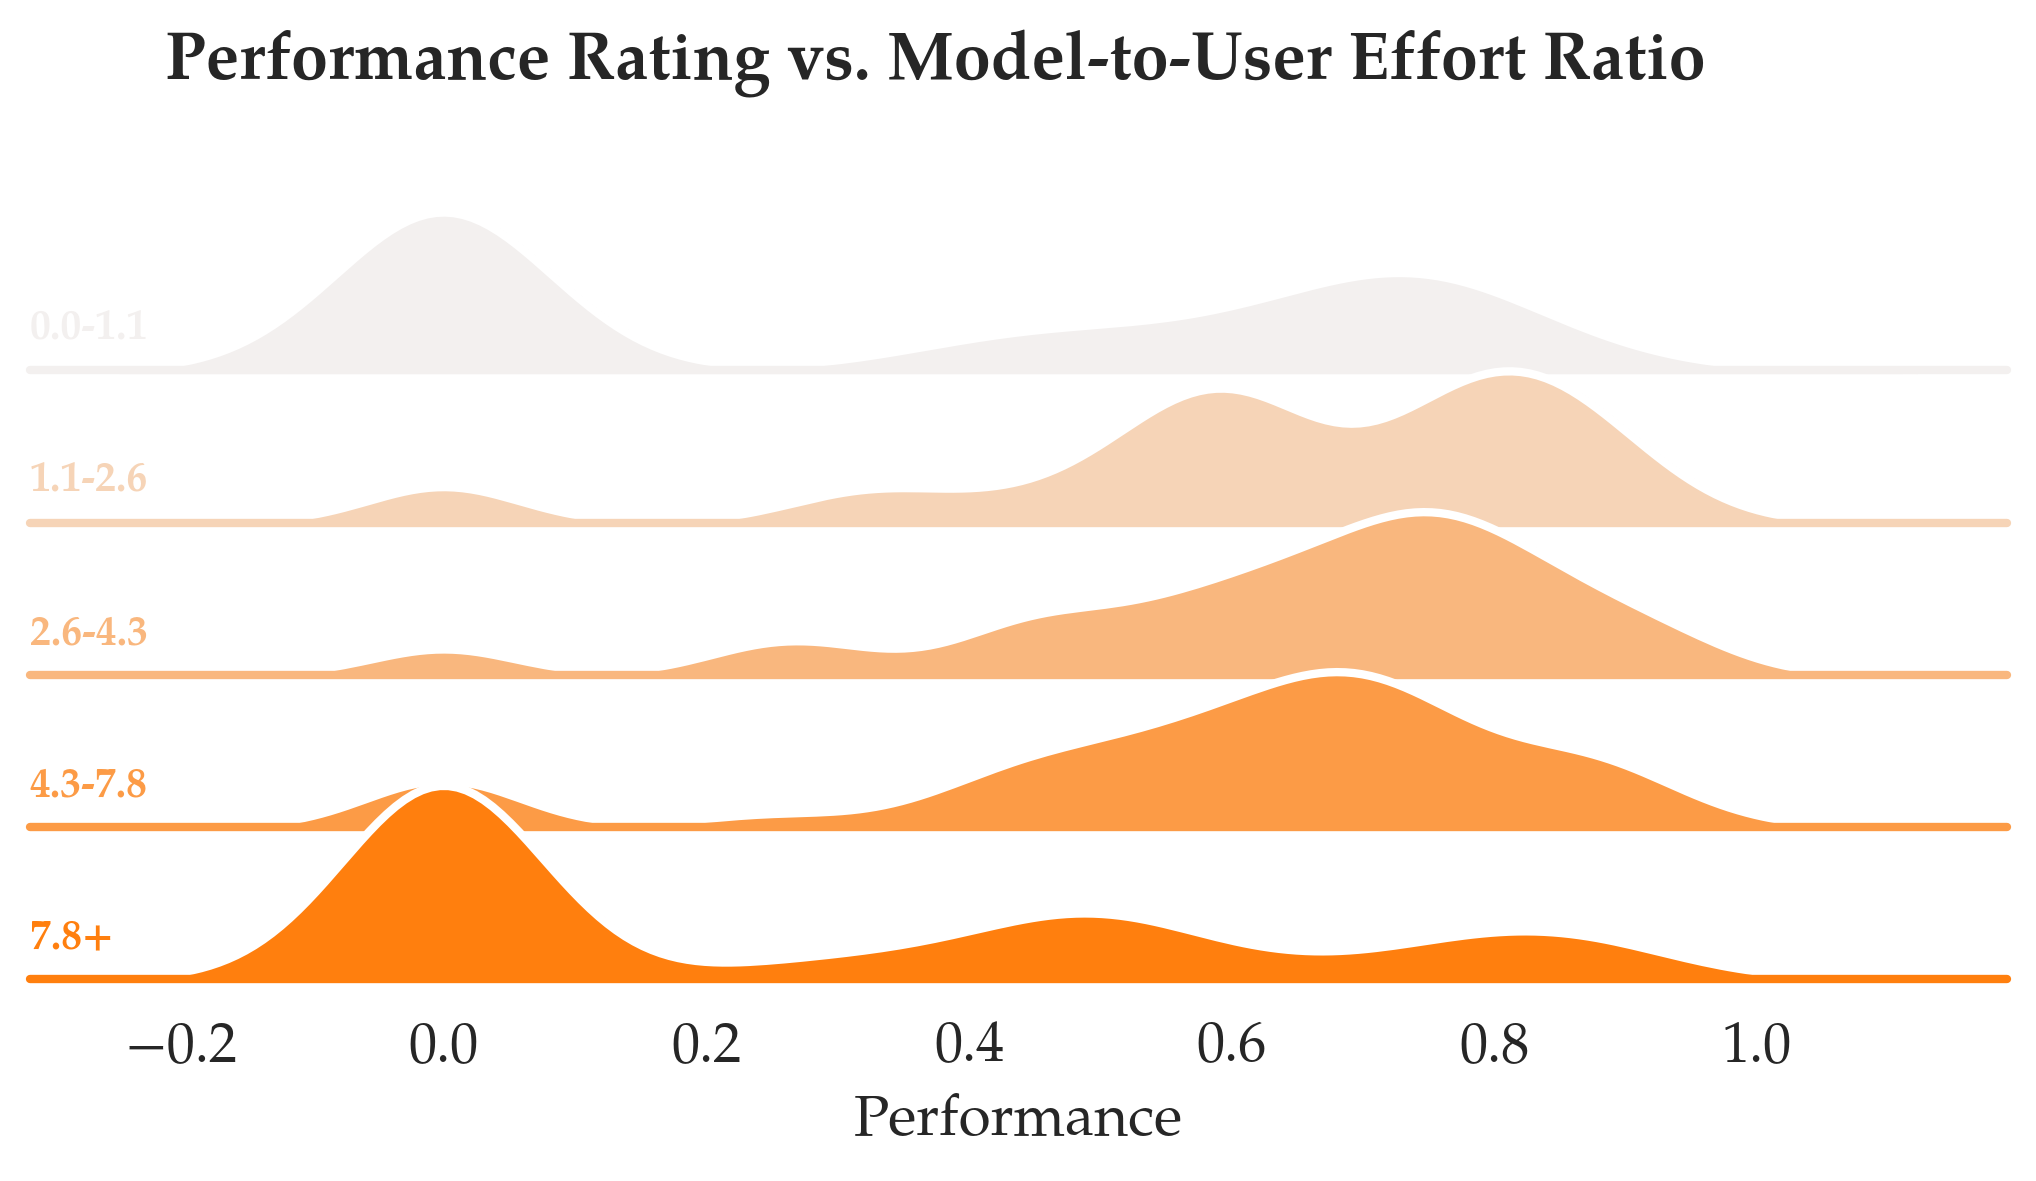

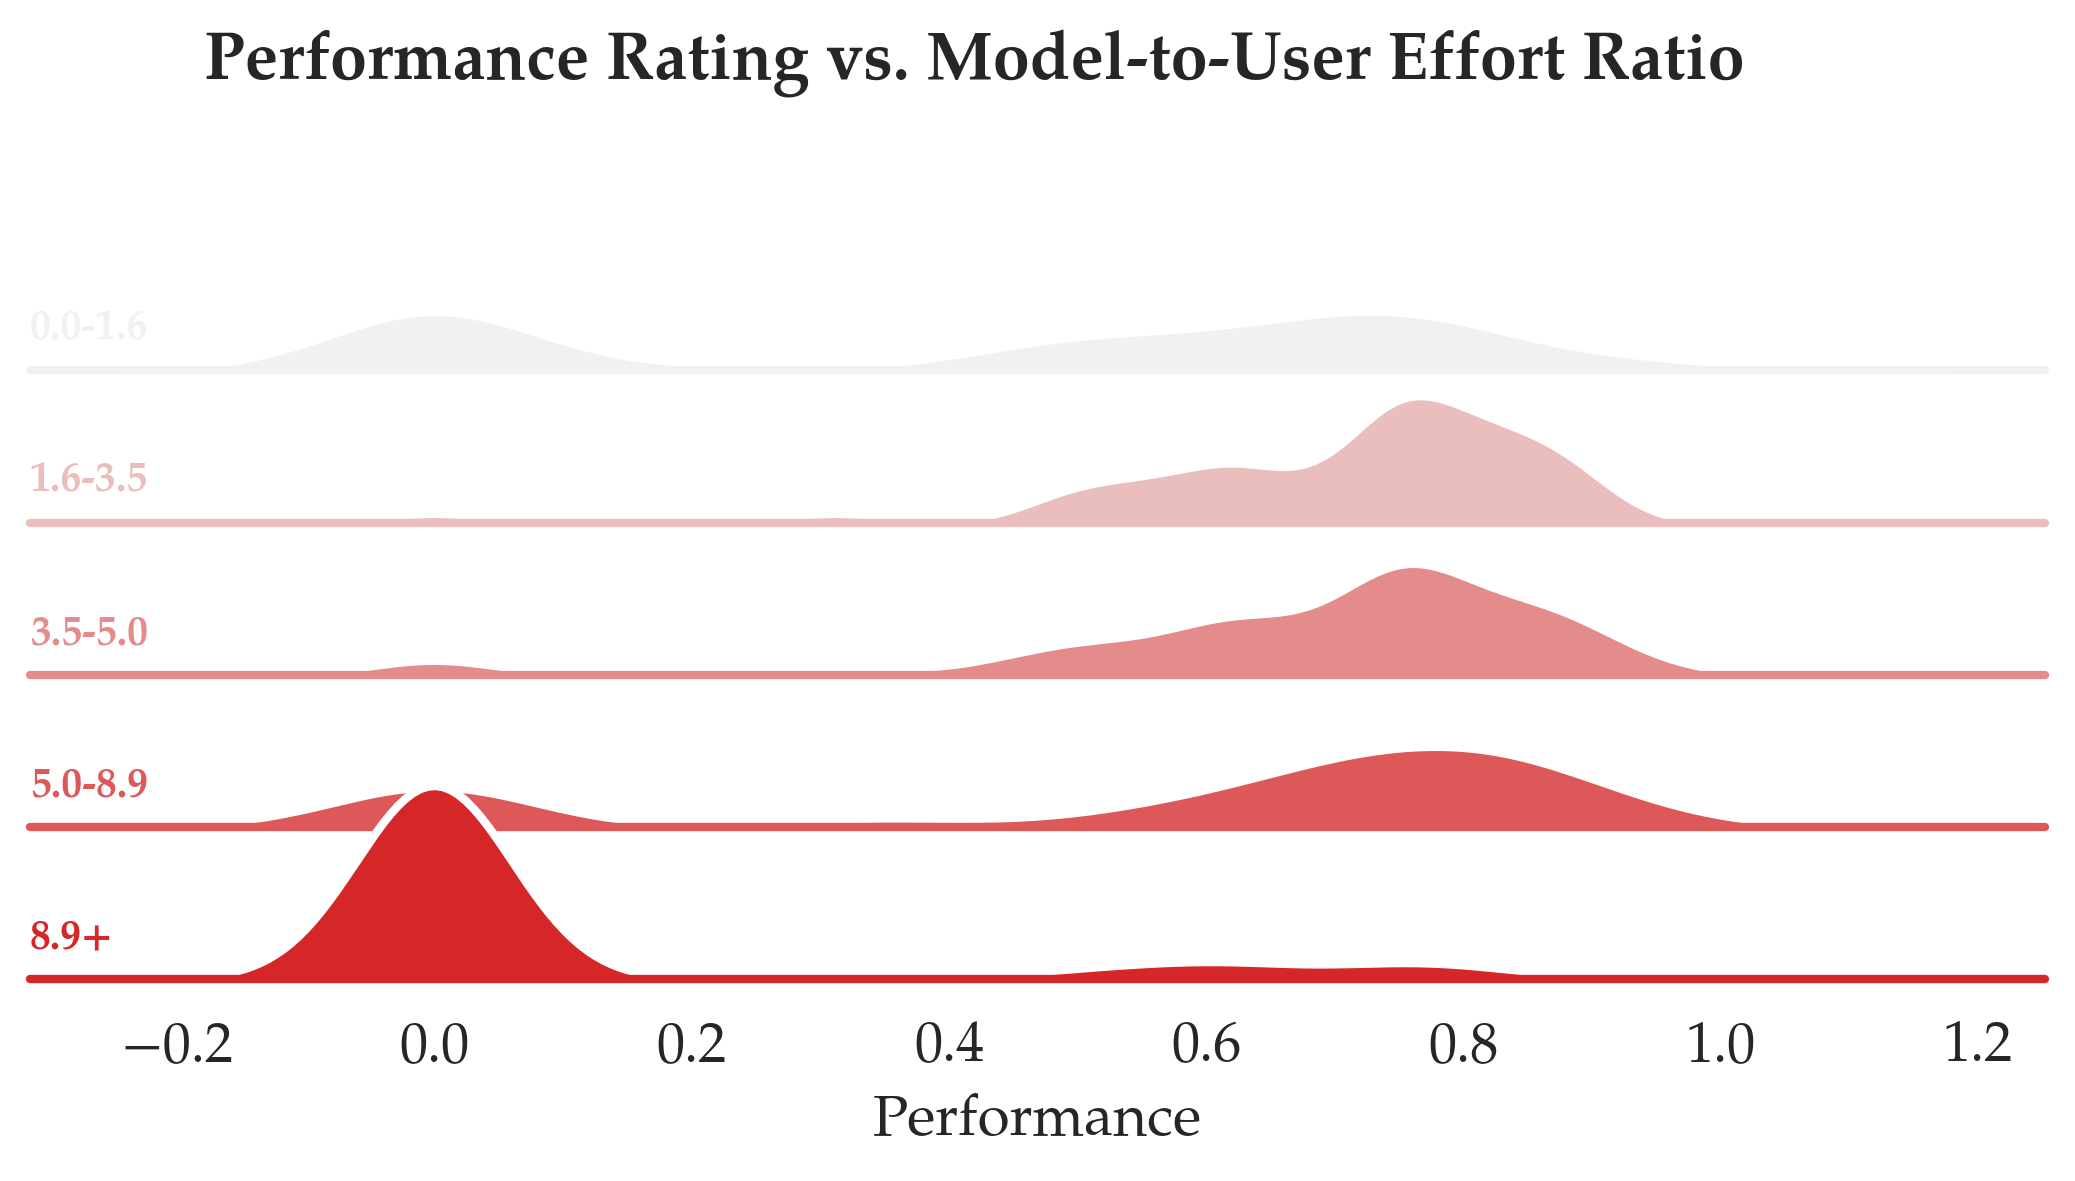

In [15]:
# Create model-specific buckets
plotting_df['ratio_bucket'] = None

# Process each model separately
for model in plotting_df['model'].unique():
    model_mask = plotting_df['model'] == model
    ratio_values = plotting_df.loc[model_mask, 'model_to_user_ratio'].dropna()
    
    if len(ratio_values) == 0:
        continue
    
    # print(f"\n{model} - Ratio distribution statistics:")
    # print(f"Min: {ratio_values.min():.2f}")
    # print(f"25th percentile: {ratio_values.quantile(0.25):.2f}")
    # print(f"Median: {ratio_values.median():.2f}")
    # print(f"75th percentile: {ratio_values.quantile(0.75):.2f}")
    # print(f"90th percentile: {ratio_values.quantile(0.90):.2f}")
    # print(f"95th percentile: {ratio_values.quantile(0.95):.2f}")
    # print(f"Max: {ratio_values.max():.2f}")
    
    # Create bins based on quantiles for this model
    quantile_bins = [0] + ratio_values.quantile([0.2, 0.4, 0.6, 0.8]).tolist() + [float('inf')]
    
    # Round the bin edges for cleaner labels
    quantile_bins = [round(b, 1) if b != float('inf') else b for b in quantile_bins]
    
    # Create labels based on the actual bin edges
    labels = [f'{quantile_bins[i]:.1f}-{quantile_bins[i+1]:.1f}' if quantile_bins[i+1] != float('inf') 
              else f'{quantile_bins[i]:.1f}+' 
              for i in range(len(quantile_bins)-1)]
    
    # print(f"Bin edges: {quantile_bins}")
    # print(f"Labels: {labels}")
    
    # Apply bins to this model's data with ordered categories
    plotting_df.loc[model_mask, 'ratio_bucket'] = pd.cut(
        plotting_df.loc[model_mask, 'model_to_user_ratio'], 
        bins=quantile_bins,
        labels=labels,
        ordered=True
    )

# Set theme for ridge plot
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Define color dictionary for models
color_dict = {
    "Claude 3.5 Sonnet": "#1f77b4",
    "GPT-4o": "#ff7f0e",
    "GPT-4 Turbo": "#2ca02c",
    "Claude 4.0 Sonnet": "#2ca02c",
    "Llama3.1 70B": "#d62728"
}

# color_dict = {
#     "Claude 3.5 Sonnet": "#1f77b4",
#     "GPT-4o": "#1f77b4",
#     "GPT-4 Turbo": "#1f77b4",
#     "Claude 4.0 Sonnet": "#1f77b4",
#     "Llama3.1 70B": "#1f77b4"
# }

# Create ridge plots for each model, showing different ratio buckets
models = plotting_df['model'].unique()

for model in models:
    model_data = plotting_df[plotting_df['model'] == model].copy()
    
    # Skip if no data for this model
    if len(model_data) == 0:
        continue
    
    # Drop rows with NaN ratio_bucket
    model_data = model_data.dropna(subset=['ratio_bucket'])
    
    if len(model_data) == 0:
        continue
    
    # Get unique buckets in order
    buckets = sorted(model_data['ratio_bucket'].unique())
    n_buckets = len(buckets)
    
    if n_buckets == 0:
        continue
    
    # Ensure ratio_bucket is categorical with proper ordering
    model_data['ratio_bucket'] = pd.Categorical(
        model_data['ratio_bucket'], 
        categories=buckets, 
        ordered=True
    )
    
    # Get base color for this model
    base_color = color_dict.get(model, "#1f77b4")  # Default to blue if model not in dict
    
    # Create palette with varying shades of the model's color
    pal = sns.light_palette(base_color, n_colors=n_buckets, reverse=False)
    
    # Initialize the FacetGrid object with row_order to ensure proper ordering
    g = sns.FacetGrid(
        model_data, 
        row="ratio_bucket",
        row_order=buckets,  # Explicitly set the row order
        hue="ratio_bucket", 
        hue_order=buckets,  # Explicitly set the hue order
        aspect=10, 
        height=.75, 
        palette=pal
    )
    
    # Draw the densities
    g.map(sns.kdeplot, "performance_rating",
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "performance_rating", 
          clip_on=False, color="w", lw=2, bw_adjust=.5)
    
    # Add reference line at y=0
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
    
    # Define function to label the plot with proper font
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontproperties=texgyrepagella_bold, color=color,
                ha="left", va="center", transform=ax.transAxes)
    
    g.map(label, "performance_rating")
    
    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.25)
    
    # Remove axes details
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    
    # Set font for x-axis ticks and label
    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_fontproperties(texgyrepagella_regular)
            label.set_fontsize(13.5)
        ax.set_xlabel("Performance", fontproperties=texgyrepagella_regular, fontsize=14)
    
    # Add overall title with proper font
    # g.figure.suptitle(f'Performance Rating Distribution - {model}', 
    #                   y=1.02, fontsize=14, fontproperties=texgyrepagella_bold)
    
    g.figure.suptitle(f'Performance Rating vs. Model-to-User Effort Ratio', 
                      y=1.02, fontsize=16, fontproperties=texgyrepagella_bold)
    
    
    # Set DPI
    g.figure.set_dpi(300)
    
    plt.show()

# Print summary statistics
bucket_stats = plotting_df.groupby(['model', 'ratio_bucket'])['performance_rating'].agg(['mean', 'count']).reset_index()
# print("\nSummary Statistics by Model and Bucket:")
# print(bucket_stats.to_string())